<a href="https://colab.research.google.com/github/mcucii/ML-projects/blob/main/Garbage%20Classification/GarbageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import classification_report, confusion_matrix
# https://www.kaggle.com/code/farzadnekouei/imbalanced-garbage-classification-resnet50

In [ ]:
#data_dir = './data/Garbage classification/'
# os.listdir(data_dir)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/ML_projects/data/Garbage classification'


In [4]:
class_names = sorted(os.listdir(data_dir))
class_to_index = {name: i for i,name in enumerate(class_names)}

images = []
labels = []
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [5]:
img_height = 128
img_width = 128

In [6]:
garbage_types = os.listdir(data_dir)

### ANALYZE DATA:

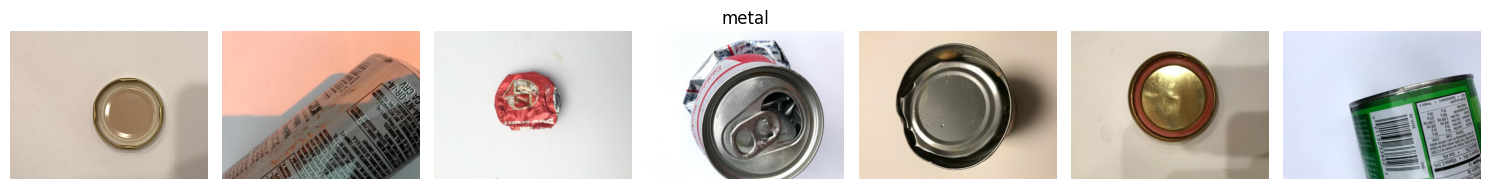

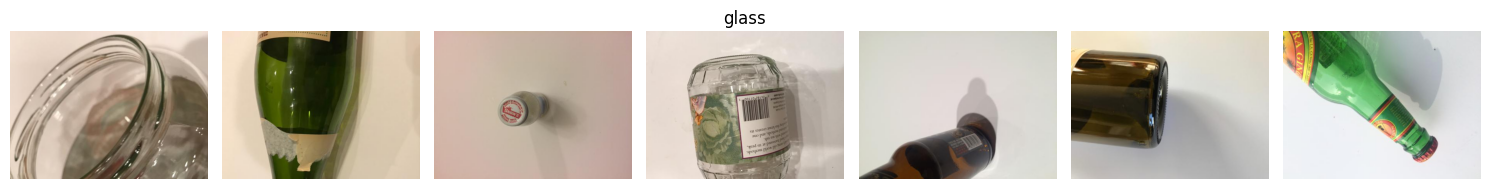

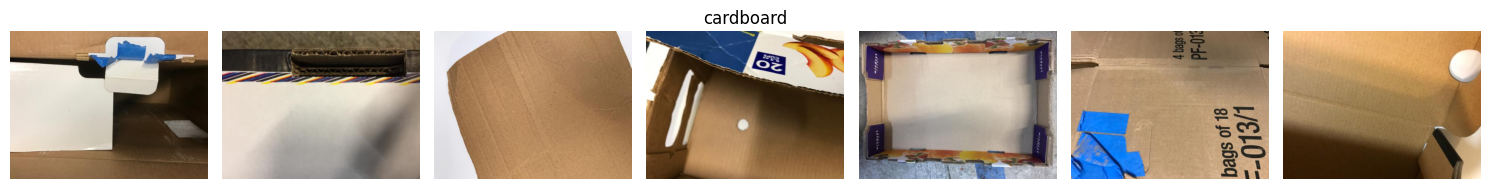

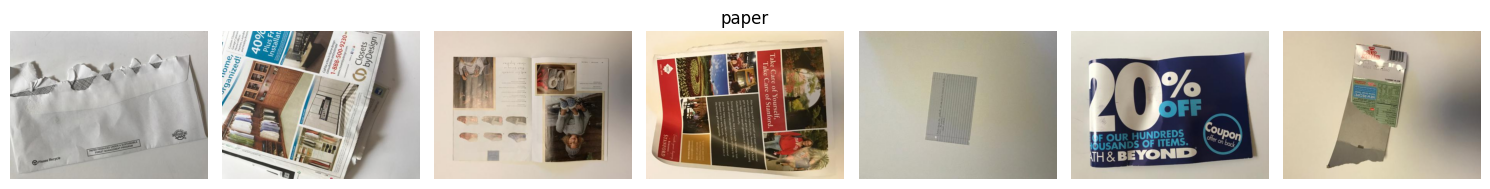

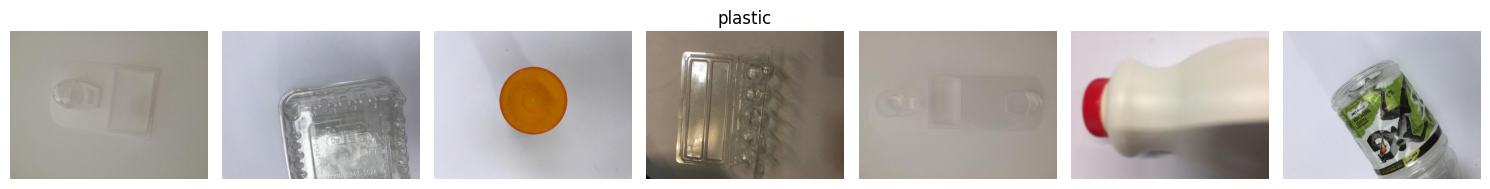

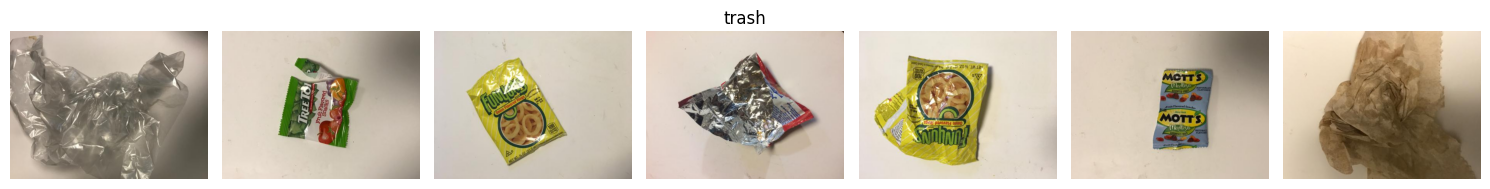

In [7]:
for garbage_type in garbage_types:
    folder_path = os.path.join(data_dir, garbage_type)
    if os.path.isdir(folder_path) :
        img_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        img_files = img_files[:7]

        fig, axs = plt.subplots(1,7, figsize=(15,2))

        for i, img_file in enumerate(img_files) :
            img_path = os.path.join(folder_path, img_file)
            with Image.open(img_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        plt.tight_layout()
        fig.suptitle(garbage_type)
        plt.show()

### DATASET PREPARATION:

In [8]:
data = []

for garbage_type in garbage_types:
    folder_path = os.path.join(data_dir, garbage_type)
    for file in os.listdir(os.path.join(data_dir, garbage_type)):
        fp = folder_path + "/" + file
        data.append((fp, garbage_type))

df = pd.DataFrame(data, columns=['filepath', 'label'])
df.head()

,filepath,label
0,/content/drive/MyDrive/ML_projects/data/Garbag...,metal
1,/content/drive/MyDrive/ML_projects/data/Garbag...,metal
2,/content/drive/MyDrive/ML_projects/data/Garbag...,metal
3,/content/drive/MyDrive/ML_projects/data/Garbag...,metal
4,/content/drive/MyDrive/ML_projects/data/Garbag...,metal


### DATA SPLIT

In [9]:
# startify - omogucava da trening i test skup imaju isti odnos klasa kao originalni skup
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"number of images in the training set: {len(train_df)}")
print(f"number of images in the validation set: {len(val_df)}")

number of images in the training set: 2021
number of images in the validation set: 506


In [10]:
# Let's verify that the distributions in the training and validation sets closely mirror the overall distribution:
overall_distribution = df['label'].value_counts(normalize=True)*100
print("Overall distribution: ")
print(overall_distribution.round(2))

train_distribution = train_df['label'].value_counts(normalize=True)*100
print("Train distribution: ")
print(train_distribution.round(2))

val_distribution = val_df['label'].value_counts(normalize=True)*100
print("Validation distribution: ")
print(val_distribution.round(2))

Overall distribution: 
label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
Train distribution: 
label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
Validation distribution: 
label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


In [11]:
# vidimo da zaista jesu sve distribucije manje vise dobre (podjednaka kolicina svakog tipa smeca u svakom skupu!)

### Data Augmentation
- technique used to expand training dataset to improve model's capacity to generalize and avoid overfitting

In [12]:
## ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,      # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15, # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
)

In [13]:
val_datagen = ImageDataGenerator(rescale=1./255)

### Generating Batches
- objasnjenje: https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_dataframe/

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(img_height, img_width),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

val_generator=val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=False
)


Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [15]:
x_batch, y_batch = next(train_generator)

Text(0.5, 1.0, '[0. 1. 0. 0. 0. 0.]')

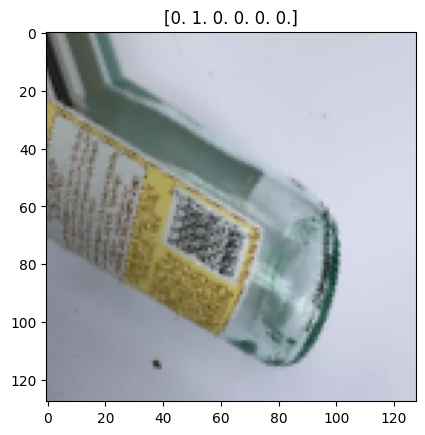

In [16]:
x_instance = x_batch[1]
y_instance = y_batch[1]

plt.imshow(x_instance)
plt.title(f"{y_instance}")

### Addresing imbalance using class weights
$weight(class) = \frac{total\_samples}{number\_of\_classes * samples\_in\_that\_class}$

In [17]:
class_labels = df['label'].unique()
class_labels

array(['metal', 'glass', 'cardboard', 'paper', 'plastic', 'trash'],
      dtype=object)

In [18]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y = train_df['label'])
weights

array([1.02693089, 0.83998337, 1.04606625, 0.70912281, 0.87489177,
       3.06212121])

In [19]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: np.float64(1.026930894308943),
 1: np.float64(0.8399833748960931),
 2: np.float64(1.0460662525879918),
 3: np.float64(0.7091228070175438),
 4: np.float64(0.8748917748917749),
 5: np.float64(3.062121212121212)}

### ResNet50
- the main feature of ResNet -> "skip" or "shortcut" connections
- core component - Residual Block

In [20]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    # implement a residual block for resNet
    # arguments:
    # X - input tensor of shape (m, height, width, channels)
    # kernel_size - integer, kernel size of the middle CONV (convolutional) layer
    # filters - python list of integers defining the number of filters in the CONV layers
    # reduce - boolean, whether to reduce spatial dimensions and increase depth; if true, applies 1x1 CONV layer to the shortcut path
    # stride - integer, strides for the CONV layer
    #
    # returns:
    # X - output of the identity block, tensor of shape (height, width, channels)

    F1, F2, F3 = filters
    X_shortcut = X

    if reduce:
        # first component of the main path
        X = Conv2D(filters=F1, kernel_size=(1,1), strides=(stride, stride), padding='valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

        X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(stride, stride), padding='valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    else:
        # first component of the main path
        X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1, 1), padding='valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

    # second component of the main path
    X = Conv2D(filters=F2, kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # third component of the main path
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)

    ## FInal step: adding shortcut to main path X
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [21]:
def ResNet50(input_shape, classes):
    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)

    # Block 2
    X = residual_block(X, kernel_size=3, filters=[64,64,256], reduce=True, stride=1)
    X = residual_block(X, kernel_size=3, filters=[64,64,256])
    X = residual_block(X, kernel_size=3, filters=[64,64,256])

    # Block 3
    X = residual_block(X, kernel_size=3, filters=[128,128,512], reduce=True, stride=2)
    X = residual_block(X, kernel_size=3, filters=[128,128,512])
    X = residual_block(X, kernel_size=3, filters=[128,128,512])
    X = residual_block(X, kernel_size=3, filters=[128,128,512])

    # Block 4
    X = residual_block(X, kernel_size=3, filters=[256,256,1024], reduce=True, stride=2)
    X = residual_block(X, kernel_size=3, filters=[256,256,1024])
    X = residual_block(X, kernel_size=3, filters=[256,256,1024])
    X = residual_block(X, kernel_size=3, filters=[256,256,1024])
    X = residual_block(X, kernel_size=3, filters=[256,256,1024])
    X = residual_block(X, kernel_size=3, filters=[256,256,1024])

    # Block 5
    X = residual_block(X, kernel_size=3, filters=[512,512,2048], reduce=True, stride=2)
    X = residual_block(X, kernel_size=3, filters=[512,512,2048])
    X = residual_block(X, kernel_size=3, filters=[512,512,2048])


    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [22]:
input_shape=(img_height, img_width,3) # defined in train gen
num_classes=6

resnet50_model = ResNet50(input_shape=input_shape, classes=num_classes)

In [24]:
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

In [25]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True, verbose=1)

In [26]:
# num_epochs = 100
# history = resnet50_model.fit(train_generator,
#                              steps_per_epoch=len(train_generator),
#                              epochs=num_epochs,
#                              validation_data=val_generator,
#                              validation_steps=len(val_generator),
#                              class_weight=class_weights,
#                              callbacks=[reduce_lr, early_stopping])



```Visualizing the learning curves```



In [28]:
def plot_learning_curves(history, start_epoch=5):
  df = pd.DataFrame(history.history)
  df = df.iloc[start_epoch-1:]
  #print(df)
  plt.figure(figsize=(15,5))

  # plot training and val loss
  plt.subplot(1,2,1)
  sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='train loss')
  sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', label='validation loss')
  plt.title('Loss evaluation')

  # plot training and val acc
  plt.subplot(1,2,2)
  sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='train accuracy')
  sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', label='validation accuracy')
  # moze i ovako
  # plt.plot(df.index, df['accuracy'], color='royalblue', label='train accuracy')
  # plt.plot(df.index, df['val_accuracy'], color='orangered', label='val accuracy')
  plt.title('Accuracy evaluation')

  plt.show()

Validation accuracy&loss fluctuates => overfitting!

In [29]:
def Modified_ResNet50(input_shape, classes):
  X_input = Input(input_shape)

  # stage 1
  X = Conv2D(64,(7,7),(2,2), kernel_initializer='he_normal')(X_input)
  X = BatchNormalization(axis=-1)(X)
  X = Activation(activation='relu')(X)
  X = MaxPooling2D((3,3), (2,2))(X)

  # stage 2
  X = residual_block(X, 3, [64,64,256], reduce=True, stride=1)
  X = residual_block(X, 3, [64,64,256])
  X = residual_block(X, 3, [64,64,256])

  # stage 3
  X = residual_block(X, 3, [128,128,512], reduce=True, stride=2)
  X = residual_block(X, 3, [128,128,512])
  X = residual_block(X, 3, [128,128,512])
  X = residual_block(X, 3, [128,128,512])

  # stage 4
  X = residual_block(X, 3, [256,256,1024], reduce=True, stride=2)
  X = residual_block(X, 3, [256,256,1024])
  X = residual_block(X, 3, [256,256,1024])
  X = residual_block(X, 3, [256,256,1024])
  X = residual_block(X, 3, [256,256,1024])
  X = residual_block(X, 3, [256,256,1024])

  # stage 5
  X = residual_block(X, 3, [512,512,2048], reduce=True, stride=2)
  X = residual_block(X, 3, [512,512,2048])
  X = residual_block(X, 3, [512,512,2048])

  X = GlobalAveragePooling2D()(X)

  # adding Dropout to prevent overfitting
  X = Dropout(0.5)(X)

  X = Dense(classes, activation='softmax')(X)

  model = Model(inputs=X_input, outputs=X, name='Modified_ResNet50')

  return model

In [30]:
input_shape=(img_height, img_width, 3)
num_classes = 6
modified_ResNet50 = Modified_ResNet50(input_shape=input_shape, classes=num_classes)

In [31]:
modified_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

In [32]:
reduce_lr =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True, verbose=1)

In [33]:
num_epochs=100
history2 = modified_ResNet50.fit(train_generator,
                      steps_per_epoch=len(train_generator),
                      epochs=num_epochs,
                      validation_data=val_generator,
                      validation_steps=len(val_generator),
                      class_weight=class_weights,
                      callbacks=[reduce_lr, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 776ms/step - accuracy: 0.2384 - loss: 3.1529 - val_accuracy: 0.1621 - val_loss: 13810.5605 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.3852 - loss: 2.0157 - val_accuracy: 0.3300 - val_loss: 1.6761 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.4565 - loss: 1.6499 - val_accuracy: 0.2174 - val_loss: 87.6645 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.4415 - loss: 1.6294 - val_accuracy: 0.2213 - val_loss: 2.1525 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.4914 - loss: 1.4383 - val_accuracy: 0.3498 - val_loss: 7.3411 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.4945 - loss: 1.4745 - val_accuracy: 0.5178 - val_loss: 2.1045 - learning_rate: 0.0010
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - accuracy: 0.50

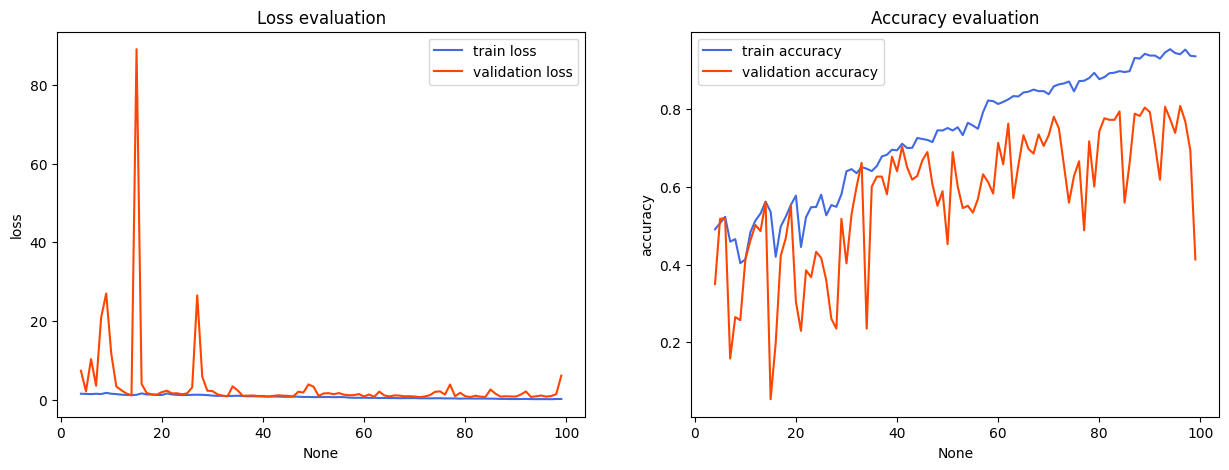

In [34]:
plot_learning_curves(history2)

In [60]:
def evaluate_performance(model, val_generator, class_labels):
  true_labels = val_generator.classes
  class_labels = list(val_generator.class_indices.keys())

  predictions = model.predict(val_generator, len(val_generator))
  predicted_labels = np.argmax(predictions, axis=1)

  report = classification_report(true_labels, predicted_labels, target_names=class_labels)
  print(report)
  print('\n')

  colors=["white", "royalblue"]
  cmap_colors = LinearSegmentedColormap.from_list(None, colors)

  cm = confusion_matrix(true_labels, predicted_labels)

  plt.figure(figsize=(4,3))
  sns.heatmap(cm, annot=True, cmap=cmap_colors, xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True labels')
  plt.title('Confusion matrix')
  plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
              precision    recall  f1-score   support

   cardboard       0.91      0.85      0.88        81
       glass       0.83      0.75      0.79       100
       metal       0.73      0.70      0.71        82
       paper       0.82      0.83      0.83       119
     plastic       0.63      0.84      0.72        97
       trash       1.00      0.52      0.68        27

    accuracy                           0.78       506
   macro avg       0.82      0.75      0.77       506
weighted avg       0.80      0.78      0.78       506





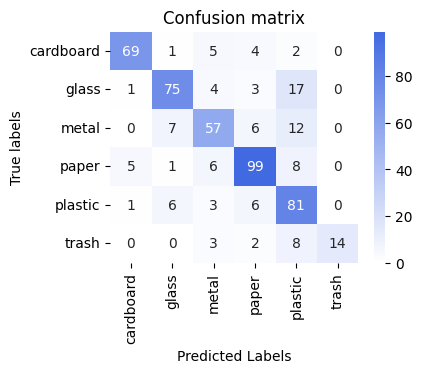

In [61]:
evaluate_performance(modified_ResNet50, val_generator, class_labels)